# <h1><center>EXPLORATORY DATA ANALYSIS</center></h1>
# <h1><center> DataGlacier Assignment</center></h1>

# <h3 align="center">  Marko Andre Talledo Herrera </h3>

# **Libraries & Configuration**

In [55]:

# Basics

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate


# Regression modelling
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

# Visualization
import dtale
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Splitting
from sklearn.model_selection import train_test_split

# Stats & Math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scy
from scipy.stats import kurtosis
from scipy import stats
from math import sqrt
import random

# Time Series Data Manipulation
import fbprophet
from pylab import rcParams
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import xlrd

In [2]:
# Showing determined number of columns
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

# Then, setting the style for our charts & plots
sns.set_style('whitegrid')
sns.set_context('notebook')

# **Cab Business Data**

In [3]:
# DATA

# Importing dataset to work with them

path = 'data/in/'
cab_data = pd.read_csv(path + 'Cab_Data.csv')
city_data = pd.read_csv(path + 'City.csv')
customerID = pd.read_csv(path + 'Customer_ID.csv')
transacID = pd.read_csv(path + 'Transaction_ID.csv')


In [6]:
# First we need to get a Dataframe that joins every characteristic of the clients
# Applying merge instance to join tables on Customer ID
df1 = transacID.merge(customerID, on='Customer ID')
df1

# Applying merge instance to join tables on City column
df2 = cab_data.merge(city_data, on='City')
df2

# Merging the last output tables on Transaction ID
# This time NAN's will appear because those trip's data is not available
data = df1.merge(df2, on="Transaction ID", how='outer')
data.head()

Transaction ID  Customer ID Payment_Mode Gender  Age  Income (USD/Month)  \
0        10000011        29290         Card   Male   28               10813   
1        10351127        29290         Cash   Male   28               10813   
2        10412921        29290         Card   Male   28               10813   
3        10000012        27703         Card   Male   27                9237   
4        10320494        27703         Card   Male   27                9237   

   Date of Travel     Company        City  KM Travelled  Price Charged  \
0         42377.0    Pink Cab  ATLANTA GA         30.45         370.95   
1         43302.0  Yellow Cab  ATLANTA GA         26.19         598.70   
2         43427.0  Yellow Cab  ATLANTA GA         42.55         792.05   
3         42375.0    Pink Cab  ATLANTA GA         28.62         358.52   
4         43211.0  Yellow Cab  ATLANTA GA         36.38         721.10   

   Cost of Trip Population     Users  
0      313.6350   814,885    24,701   
1      317.4228   814,885    24,701   
2      597.4020   814,885    24,701   
3      334.8540   814,885    24,701   
4      467.1192   814,885    24,701

### I had merge on Transaction ID because each Customer has many Transactions


# **Exploration**

## **Quick View**

In [119]:

# Let's Watch a first view about how our variables are distributed, and if exists outliers and null values
d = dtale.show(data)
d.open_browser()


## **NA's Treatment**

In [7]:
# There are 80706 entries with NAN data, we must seek for imput them
# or delete them, but we will se the best way to approach it

data.isnull().sum()

Transaction ID            0
Customer ID               0
Payment_Mode              0
Gender                    0
Age                       0
Income (USD/Month)        0
Date of Travel        80706
Company               80706
City                  80706
KM Travelled          80706
Price Charged         80706
Cost of Trip          80706
Population            80706
Users                 80706
dtype: int64

### We can see that every column has the same number of null data. It's not caused by the columns, instead, it is caused by many customers has not available information, that's why we will try to get the nulls per each customer

In [17]:
# Creating a dataframe that displays transaction count per each
# customer ID
val_customer = pd.DataFrame(data['Customer ID'].value_counts())
val_customer.reset_index(level=0, inplace=True)
val_customer = val_customer.rename({'index': 'Customer ID',
                                    'Customer ID': 'count'},
                                    axis=1)


In [18]:
# Creating a dataframe that shows the count of the transactions
# with NAN data for each customer
nan_customer = pd.DataFrame(
    data.loc[(data['Company'].isnull()), ['Customer ID']].value_counts())
nan_customer.reset_index(level=0, inplace=True)
nan_customer = nan_customer.rename(
    {'index': 'Customer ID', 0: 'nan_count'}, axis=1)



In [19]:
# Merging last two tables in order to compare quantities
val_customer = val_customer.merge(nan_customer, on="Customer ID")

# Then we look for the percentage of NAN entries in each customer
val_customer['nan_per'] = round(
    (val_customer['nan_count']/val_customer['count'])*100, 2)
val_customer = val_customer.sort_values(by='nan_per', ascending=True)
val_customer


Customer ID  count  nan_count  nan_per
0            2539     50          1     2.00
1             442     49          1     2.04
5             533     45          1     2.22
11             59     43          1     2.33
25            390     42          1     2.38
...           ...    ...        ...      ...
1248        43988     28         28   100.00
1249        43853     28         28   100.00
1250        44328     28         28   100.00
1226        42228     28         28   100.00
3513        35145      1          1   100.00

[3514 rows x 4 columns]

### We'll assume that the information of every customer that has 50% NAN data or more is not useful because they are not loyal customers for our company. So We'll proceed to clean that data

In [20]:
# First we will get a list of those clients
droplist = val_customer.loc[val_customer['nan_per'] >= 50, ['Customer ID']]


In [21]:
# Then we iterate for filtering the dataframe
for c in droplist['Customer ID']:
    data = data[data['Customer ID'] != c]
print(data.shape)

(359831, 14)


In [23]:
# Variation of the number of rows between the original dataframe and the updated one
var = df1.shape[0] - data.shape[0]
var

80267

In [24]:
# Now, the count of NAN data that belongs to the updated dataset
data.isnull().sum()


Transaction ID          0
Customer ID             0
Payment_Mode            0
Gender                  0
Age                     0
Income (USD/Month)      0
Date of Travel        469
Company               469
City                  469
KM Travelled          469
Price Charged         469
Cost of Trip          469
Population            469
Users                 469
dtype: int64

### With this evidence, we can see that most of the NaN customer data is not useful. Also, the tiny part of NaN data is too short and not significant enough to be imputed.

In [25]:
# That's why it's better to go back
# few steps and merging df1 and df1 with inner joined

data = df1.merge(df2, on="Transaction ID", how='inner')
data.shape

(359392, 14)

In [26]:
# That decision made us lost this percentage of the total amount of data
dataloss = var*100/df1.shape[0]
dataloss
# 18.34% of loss, it is not that bad at all


18.238437802489447

## **Used Functions**

In [113]:
# FUNCTIONS

# TABLE FUNCTION FOR CATEGORY VARIABLES


def tab(data, col1, col2="Freq", norm=False, marg=True, marg_name='Total'):
    # Warning
    if ((col2 != "Freq") & (col2 not in data.columns)) | (col1 not in data.columns):
        print('There is at least one column that not belongs to the dataframe')
        return
    # Absolute Frequency table
    if col2 == "Freq":
        if norm == False:
            tab = pd.crosstab(index=data[col1], columns=col2, normalize=False,
                            margins=marg, margins_name='Total')
    # Relative Frequency
        else:
            tab = pd.crosstab(index=data[col1], columns=col2, normalize=True,
                            margins=marg, margins_name='Total').round(4).apply(lambda r: r*100, axis=1)
    # Relative frequencies with 2 variables
    elif (col2 != "Freq") & (norm == True):
        tab = pd.crosstab(index=data[col1], columns=data[col2], normalize=True,
                        margins=marg, margins_name='Total').round(4).apply(lambda r: r*100, axis=1)
    # Absolute frequencies for 2 variables
    else:
        tab = pd.crosstab(index=data[col1], columns=data[col2], normalize=False,
                        margins=marg, margins_name='Total')
    return tab


# COUNTPLOT FUNCTION
colors_list = list(colors._colors_full_map.values()) # To adding a little bit of fun to our plots

def cntplot(x, data, title):
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    sns.catplot(x=x,
                data=data,
                kind='count',
                palette=random.choices(colors_list, k=2), 
                edgecolor='black',
                linewidth=1.25)
    plt.title(title, fontsize=16, weight='bold')


# PIE CHART FUNCTION
def pieplot(data, catcol, title):
    tab(data, catcol,
        norm=True, marg=False).plot(kind='pie',
                                    autopct='%.2f',
                                    colors=random.choices(colors_list, k=2),
                                    subplots=True,
                                    wedgeprops={'linewidth': 1.5,
                                                'edgecolor': 'black'})
    plt.title(title, fontsize=16, weight='bold')


# DISPERSION MEASURES FOR NUMERIC VARIABLES
def disper_table(data, col):
    table = [['std_%s' % (col[0:2]), 'var_%s' % (col[0:2]), 'cv_%s' % (col[0:2]), 'skew_%s' % (col[0:2]),
            'kurt_%s' % (col[0:2])],
            [data[col].std(ddof=0), data[col].var(ddof=0),
            stats.variation(data[col]), stats.skew(data[col]), kurtosis(data[col], fisher=True)]]
    return pd.DataFrame(table, columns=table[0]).drop([0])


# OUTLIER REMOVER
def outlier_remover(data, cuantcol, cualcol):
    for c in data[cuantcol].unique():
        Q1 = data.loc[data[cualcol] == c, [cuantcol]].quantile(0.25)
        Q3 = data.loc[data[cualcol] == c, [cuantcol]].quantile(0.75)
        IQR = Q3 - Q1
        LL = float(Q1 - 1.5*IQR)
        RL = float(Q3 + 1.5*IQR)
        cond1 = (data[cualcol] == c) & (data[cuantcol] >= LL)
        cond2 = (data[cualcol] == c) & (data[cuantcol] <= RL)
        if c == data[cualcol].unique()[0]:
            data_out = data.loc[cond1 & cond2, :]
        else:
            dummy = data.loc[cond1 & cond2, :]
            data_out = pd.concat([data_out, dummy])
        print(data_out.shape)

['PuBu']

## **Data Manipulation & Visualization**

### **Data Types and Customization**

In [30]:
# We have to change the data type to string
data['Customer ID'] = data['Customer ID'].astype('string')
data['Transaction ID'] = data['Transaction ID'].astype('string')

In [31]:
# Income got renamed
data.rename(columns={'Income (USD/Month)': 'Income'}, inplace=True)

In [32]:
# Transforming to date format
data['Date of Travel'] = data['Date of Travel'].apply(
    lambda s: xlrd.xldate.xldate_as_datetime(s, 0))

In [33]:
# Transforming strings to floats
data['Population'] = data['Population'].str.replace(',', '').astype(float)
data['Users'] = data['Users'].str.replace(',', '').astype(float)

### **New Variables and KPIS**

In [35]:
# Profit variable - We need to see what amount of money is gained per service
data['Profit'] = data['Price Charged'] - data['Cost of Trip']
data['Profit']

0          57.3150
1         281.2772
2         194.6480
3          23.6660
4         253.9808
            ...   
359387     47.2656
359388    105.0980
359389     71.2100
359390     21.8600
359391     64.3020
Name: Profit, Length: 359392, dtype: float64

In [34]:
# Unit Cost per KM Travelled
data['cost_per_km'] = data['Cost of Trip'] / data['KM Travelled']
data['cost_per_km']


0         10.30
1         12.12
2         14.04
3         11.70
4         12.84
          ...  
359387    12.84
359388    12.60
359389    12.24
359390    12.60
359391    13.56
Name: cost_per_km, Length: 359392, dtype: float64

In [36]:
# Profit that is gained per KM Travelled
data['profit_per_km'] = data['Profit'] / data['KM Travelled']
data['profit_per_km']

0          1.882266
1         10.739870
2          4.574571
3          0.826904
4          6.981330
            ...    
359387     2.837071
359388     7.660204
359389     3.747895
359390     3.903571
359391     4.834737
Name: profit_per_km, Length: 359392, dtype: float64

### **General Visualization**

VARIABLES NUMÉRICAS

IndexError: index 8 is out of bounds for axis 0 with size 8

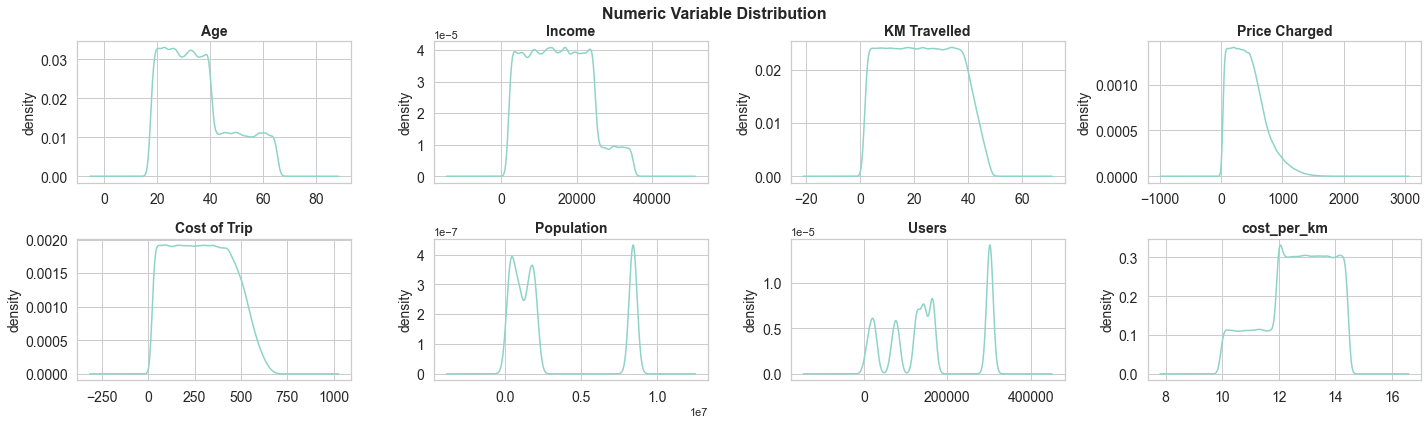

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))
axes = axes.flat
columnas_object = data.select_dtypes(include=['float', 'int64']).columns

for i, col in enumerate(columnas_object):
    data[col].plot.kde(ax = axes[i])
    axes[i].set_title(col, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 14)
    axes[i].set_ylabel("density", fontsize = 14)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Numeric Variable Distribution',
            fontsize = 16, fontweight = "bold");

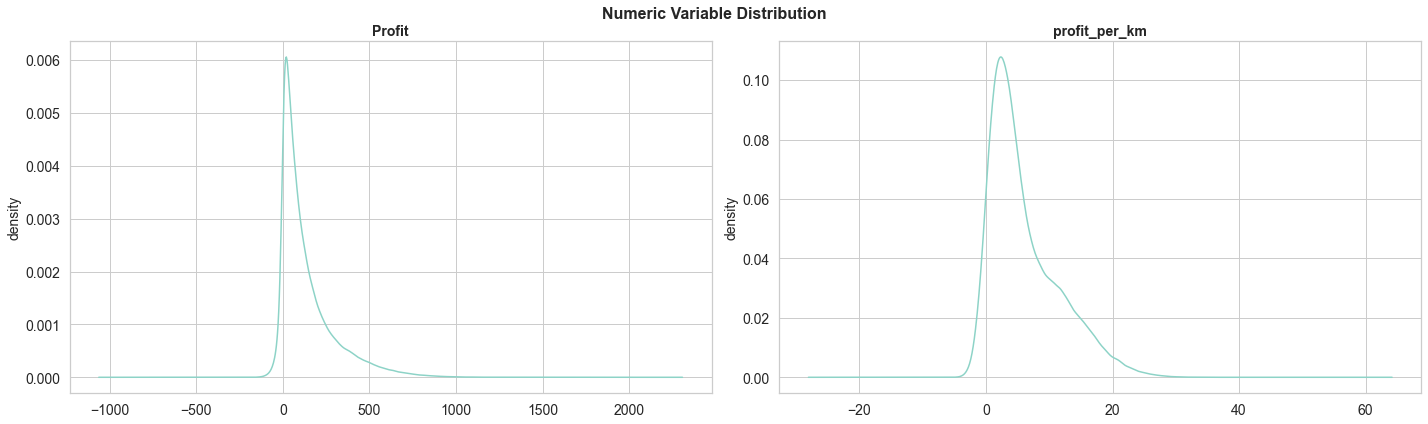

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axes = axes.flat
for i, col in enumerate(['Profit', 'profit_per_km']):
        data[col].plot.kde(ax = axes[i])
        axes[i].set_title(col, fontsize = 14, fontweight = "bold")
        axes[i].tick_params(labelsize = 14)
        axes[i].set_ylabel("density", fontsize = 14)
        fig.tight_layout()
        plt.subplots_adjust(top=0.9)
        fig.suptitle('Numeric Variable Distribution',
                fontsize = 16, fontweight = "bold");

CATEGORIC VARIABLES

In [47]:
data.head()

Transaction ID Customer ID Payment_Mode Gender  Age  Income Date of Travel  \
0       10000011       29290         Card   Male   28   10813     2016-01-08   
1       10351127       29290         Cash   Male   28   10813     2018-07-21   
2       10412921       29290         Card   Male   28   10813     2018-11-23   
3       10000012       27703         Card   Male   27    9237     2016-01-06   
4       10320494       27703         Card   Male   27    9237     2018-04-21   

      Company        City  KM Travelled  Price Charged  Cost of Trip  \
0    Pink Cab  ATLANTA GA         30.45         370.95      313.6350   
1  Yellow Cab  ATLANTA GA         26.19         598.70      317.4228   
2  Yellow Cab  ATLANTA GA         42.55         792.05      597.4020   
3    Pink Cab  ATLANTA GA         28.62         358.52      334.8540   
4  Yellow Cab  ATLANTA GA         36.38         721.10      467.1192   

   Population    Users  cost_per_km    Profit  profit_per_km  
0    814885.0  24701.0        10.30   57.3150       1.882266  
1    814885.0  24701.0        12.12  281.2772      10.739870  
2    814885.0  24701.0        14.04  194.6480       4.574571  
3    814885.0  24701.0        11.70   23.6660       0.826904  
4    814885.0  24701.0        12.84  253.9808       6.981330

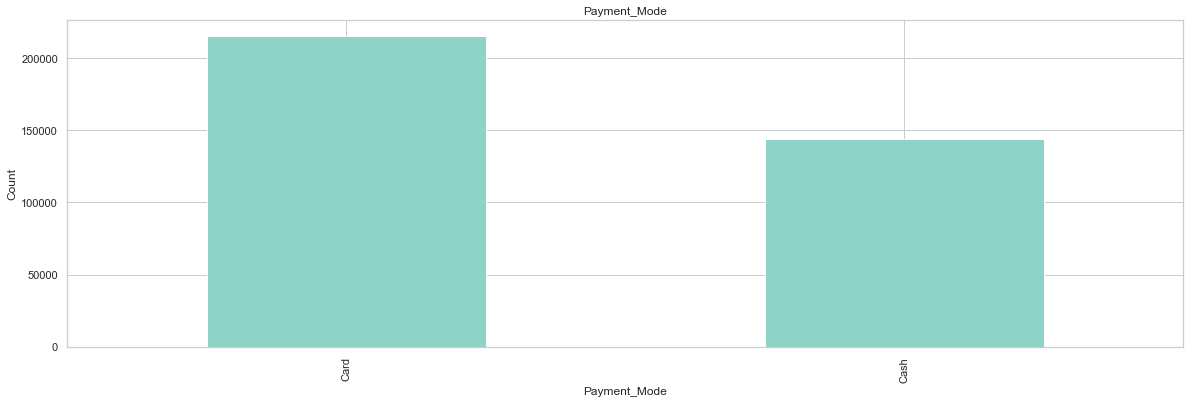

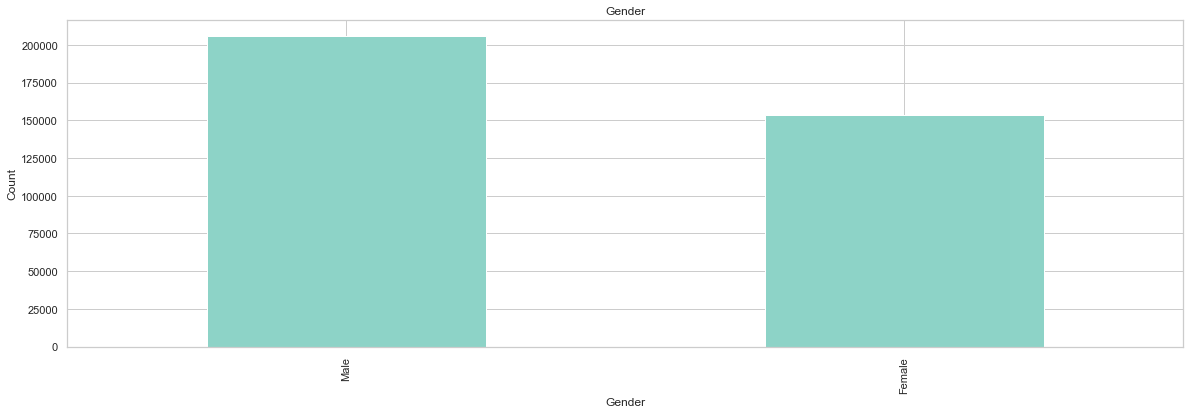

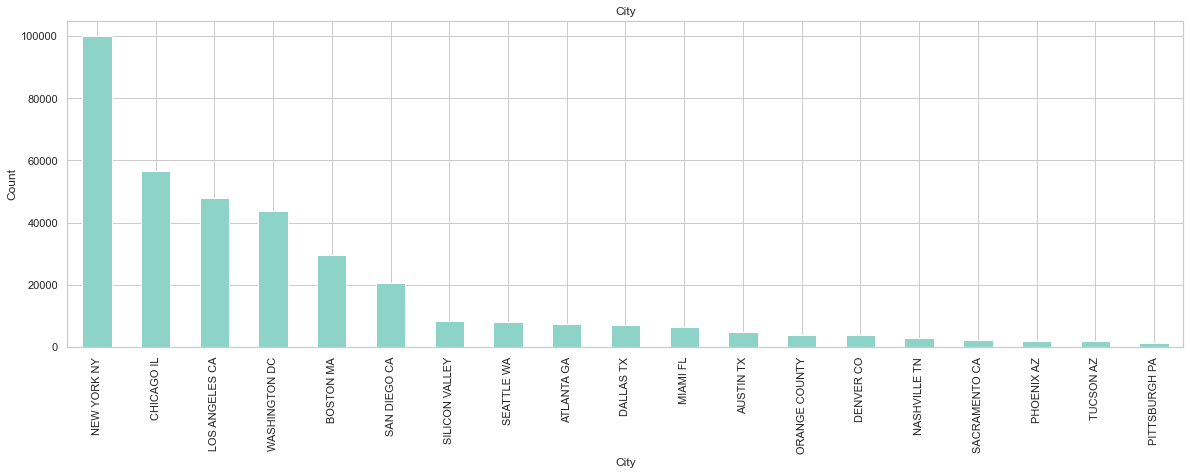

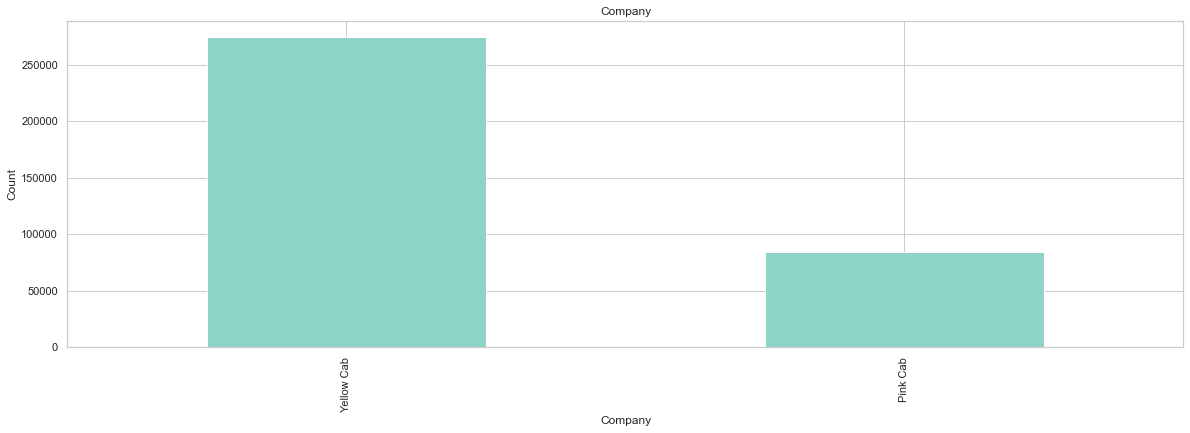

In [49]:
catvars = ['Payment_Mode', 'Gender', 'City', 'Company']
for var in catvars:
    for feature in [var]:
        var = data.groupby(feature)[feature].count().sort_values(ascending = False)
        fig, ax1 = plt.subplots(figsize=(20, 6))
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Count')
        ax1.set_title(feature)
        var.plot(kind='bar')
        plt.show()

### **Analysis per Variable**

In [51]:
# PAYMENT MODE
data['Payment_Mode'].describe()

# The most used modality of payment that users take is Card Transaction

count     359392
unique         2
top         Card
freq      215504
Name: Payment_Mode, dtype: object

In [53]:
tab(data, 'Payment_Mode', norm=True)

# Relative Frequencies for this variable: Card transactions covers the 60% percent of all
# transactions in our dataset, that indicates that users prefer this modality
# We should position many offers to the other part to change into the card modality

col_0           Freq   Total
Payment_Mode                
Card           59.96   59.96
Cash           40.04   40.04
Total         100.00  100.00

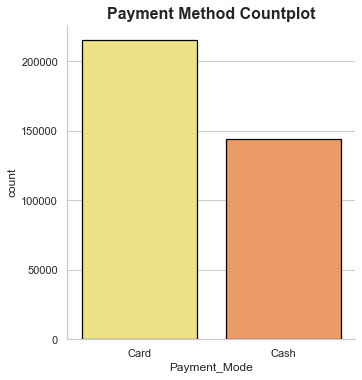

In [111]:
# We use the piechart and the countplot for visualize our data

cntplot(data['Payment_Mode'], data, title='Payment Method Countplot')

In [84]:
# GENDER VARIABLE
data['Gender'].describe()
# We see that most of our users are males

count     359392
unique         2
top         Male
freq      205912
Name: Gender, dtype: object

In [74]:
tab(data, 'Gender', norm=True)

# In Fact, Male population represent at least the 57% of the total users 

col_0     Freq   Total
Gender                
Female   42.71   42.71
Male     57.29   57.29
Total   100.00  100.00

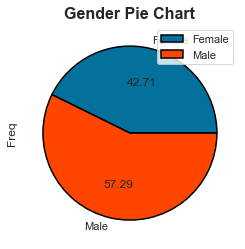

In [114]:
# We use the piechart and the countplot for visualize our data
pieplot(data, 'Gender', title='Gender Pie Chart')


In [115]:
#AGE VARIABLE
data['Age'].describe()


# At least 75% of the cab consumers are under 42 years

count    359392.000000
mean         35.336705
std          12.594234
min          18.000000
25%          25.000000
50%          33.000000
75%          42.000000
max          65.000000
Name: Age, dtype: float64

In [118]:
# Now, It's dispersion metrics
disper_table(data, 'Age')


# There is not so much variation inside this variable. 
# It is a platykurtic distribution
# And It is moderately skewed to the right tail

std_Ag      var_Ag     cv_Ag   skew_Ag   kurt_Ag
1  12.594217  158.614301  0.356406  0.685336 -0.458407

<AxesSubplot:>

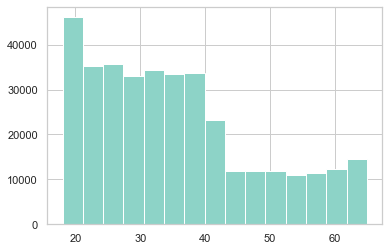

In [116]:
# Distribution of the variable
data['Age'].hist(bins=15)

<AxesSubplot:xlabel='Age'>

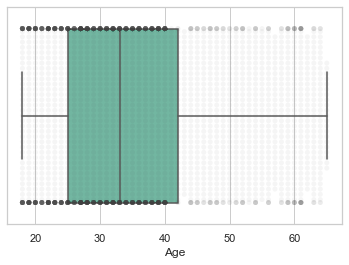

In [117]:
# %%
# Let's see how it is distributed by a Boxplot and a Histrogram
sns.boxplot(x='Age', data=data, linewidth=1.5, orient="h", palette="Set2")
sns.swarmplot(x="Age", data=data.sample(frac=.01), color=".25", alpha=0.05)

In [122]:
# INCOME VARIABLE
data['Income'].describe()
# Most of the customers that use the cab service gain a wage above USD2000 monthly
# Just the 25% of users that are the highest level reach monthly wages up to USD 21000

count    359392.000000
mean      15048.822937
std        7969.409482
min        2000.000000
25%        8424.000000
50%       14685.000000
75%       21035.000000
max       35000.000000
Name: Income, dtype: float64

In [123]:

disper_table(data, 'Income')
# Not big  CV, data is concentrated
# Moderately skewed at the right tail
# Platykurtic distribution, data is far from the center

std_In           var_In    cv_In   skew_In   kurt_In
1  7969.398395  63511310.770973  0.52957  0.309561 -0.660493

<AxesSubplot:>

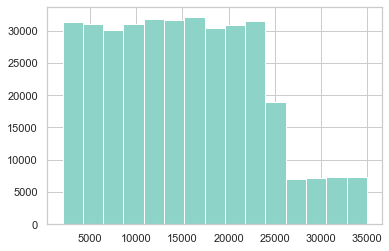

In [124]:

# %%
# Distribution of the variable
data['Income'].hist(bins=15)



<AxesSubplot:>

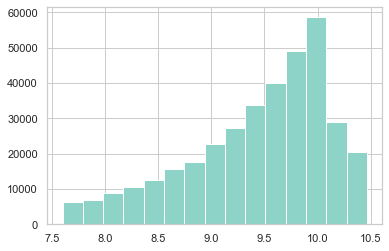

In [125]:
# Let's see if a logaritmic transformation could help us
np.log(data['Income']).hist(bins=15)

# The distribution is well defined, but It doesn't appear similar as a Normal Distribution

<AxesSubplot:xlabel='Income'>

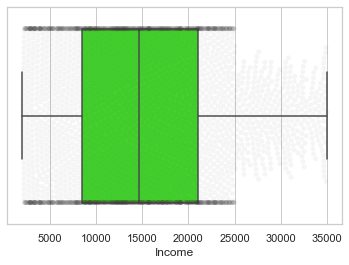

In [126]:
# %%
sns.boxplot(x='Income', data=data, linewidth=1.5, orient="h",
            palette=random.choices(colors_list, k=1))
sns.swarmplot(x="Income", data=data.sample(frac=.01), color=".25", alpha=0.05)

In [127]:
# COMPANY VARIABLE
data['Company'].describe()

# Most users prefer to use Yellow Cab Company, we should try to target our service relying on the information about Yellow Cab

count         359392
unique             2
top       Yellow Cab
freq          274681
Name: Company, dtype: object

In [128]:
tab(data, 'Company', norm=True)
# As We suposed, the prefered company is Yellow Cab

col_0         Freq   Total
Company                   
Pink Cab     23.57   23.57
Yellow Cab   76.43   76.43
Total       100.00  100.00

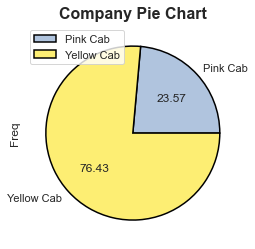

In [192]:
# Let's visualize the preference
pieplot(data, 'Company', title='Company Pie Chart')



In [193]:
# CITY VARIABLE
data['City'].describe()


count          359392
unique             19
top       NEW YORK NY
freq            99885
Name: City, dtype: object

In [197]:
tab(data, 'City', norm=True).sort_values(by = 'Freq', ascending = False)

col_0             Freq   Total
City                          
Total           100.00  100.00
NEW YORK NY      27.79   27.79
CHICAGO IL       15.76   15.76
LOS ANGELES CA   13.37   13.37
WASHINGTON DC    12.17   12.17
BOSTON MA         8.26    8.26
SAN DIEGO CA      5.70    5.70
SILICON VALLEY    2.37    2.37
SEATTLE WA        2.23    2.23
ATLANTA GA        2.10    2.10
DALLAS TX         1.95    1.95
MIAMI FL          1.80    1.80
AUSTIN TX         1.36    1.36
ORANGE COUNTY     1.11    1.11
DENVER CO         1.06    1.06
NASHVILLE TN      0.84    0.84
SACRAMENTO CA     0.66    0.66
PHOENIX AZ        0.57    0.57
TUCSON AZ         0.54    0.54
PITTSBURGH PA     0.37    0.37

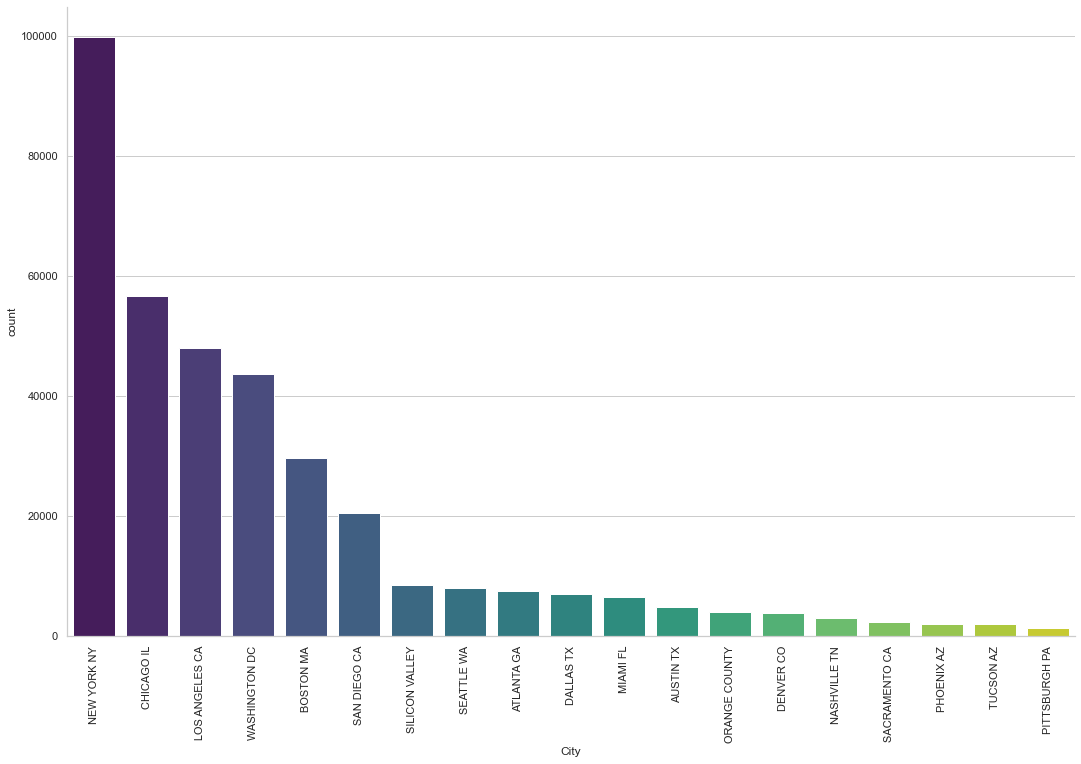

In [205]:
# Order cities by frequency
order = data['City'].value_counts().sort_values(ascending=False)
order.shape

# Plotting the cities
sns.set_context('notebook')
a = sns.catplot(x=data['City'], data=data,
            kind='count', order=order.index,
            palette="viridis")
plt.xticks(rotation=90)
a.fig.set_size_inches(20, 10)

In [206]:
# KM TRAVELLED VARIABLE
data['KM Travelled'].describe()

# 50% of the rides travel more than 22.4 kilometers


count    359392.000000
mean         22.567254
std          12.233526
min           1.900000
25%          12.000000
50%          22.440000
75%          32.960000
max          48.000000
Name: KM Travelled, dtype: float64

In [207]:
disper_table(data, 'KM Travelled')

# Not too much variation
# Almost nothing skewed
# Platykurtic distribution

std_KM     var_KM     cv_KM   skew_KM   kurt_KM
1  12.233509  149.65874  0.542091  0.055779 -1.126876

<AxesSubplot:xlabel='KM Travelled'>

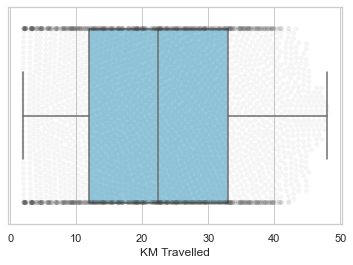

In [208]:
# KM Travelled Boxplot
sns.boxplot(x='KM Travelled', data=data, linewidth=1.5, orient="h",
            palette=random.choices(colors_list, k=1))
sns.swarmplot(x='KM Travelled', data=data.sample(
    frac=.01), color=".25", alpha=0.05)

In [209]:
# PRICE CHARGED
data['Price Charged'].describe()

# 75% of the rides charges more then 200 USD to the users


count    359392.000000
mean        423.443311
std         274.378911
min          15.600000
25%         206.437500
50%         386.360000
75%         583.660000
max        2048.030000
Name: Price Charged, dtype: float64

In [211]:
disper_table(data, 'Price Charged')




std_Pr        var_Pr    cv_Pr   skew_Pr   kurt_Pr
1  274.37853  75283.577571  0.64797  0.873758  0.747608

<AxesSubplot:>

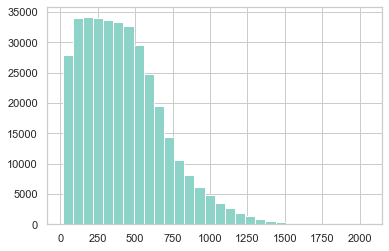

In [212]:
# Price Charged Histogtam
data['Price Charged'].hist(bins=30)



<AxesSubplot:xlabel='Price Charged'>

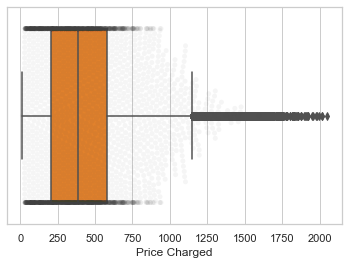

In [213]:
# Let's see how this variable is distributed

sns.boxplot(x='Price Charged', data=data, linewidth=1.5, orient="h",
            palette=random.choices(colors_list, k=1))
sns.swarmplot(x='Price Charged', data=data.sample(
    frac=.01), color=".25", alpha=0.05)

In [214]:
# There are many outliers in the 'Price Charged' Variable, it is better to
# drop them in order to clean our data. Interquartile Range method is going to
# be used

Q1 = data['Price Charged'].quantile(0.25)
Q3 = data['Price Charged'].quantile(0.75)

IQR = Q3 - Q1

data = data[(data['Price Charged'] >= (Q1 - 1.5*IQR)) &
            (data['Price Charged'] <= (Q3 + 1.5*IQR))]

<AxesSubplot:xlabel='Price Charged'>

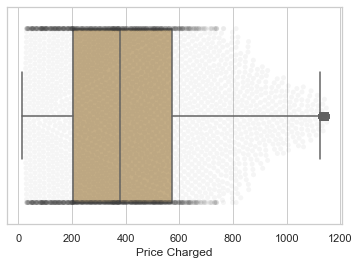

In [215]:
# Let's see again the variable
sns.boxplot(x='Price Charged', data=data, linewidth=1.5, orient="h",
            palette=random.choices(colors_list, k=1))
sns.swarmplot(x='Price Charged', data=data.sample(
    frac=.01), color=".25", alpha=0.05)

In [217]:
# COST OF THE TRIP VARIABLE
data['Cost of Trip'].describe()

count    353434.000000
mean        281.984525
std         155.727585
min          19.000000
25%         149.104800
50%         277.819200
75%         407.232000
max         691.200000
Name: Cost of Trip, dtype: float64

<AxesSubplot:>

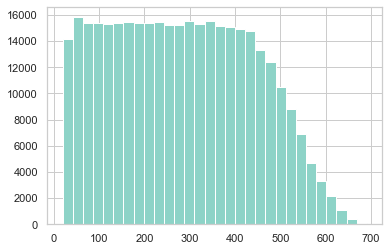

In [219]:
data['Cost of Trip'].hist(bins=30)

<AxesSubplot:xlabel='Cost of Trip'>

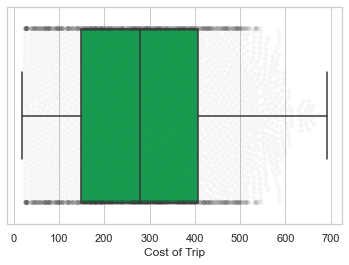

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2021-08-06 22:03:16,131 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...


2021-08-06 22:03:20,564 - INFO     - Executing shutdown...


In [220]:
# 
sns.boxplot(x='Cost of Trip', data=data, linewidth=1.5, orient="h",
            palette=random.choices(colors_list, k=1))
sns.swarmplot(x='Cost of Trip', data=data.sample(
    frac=.01), color=".25", alpha=0.05)